## Single Item Recommender System

Here is a [better rendering](https://nbviewer.org/github/facebookresearch/Pearl/blob/main/tutorials/single_item_recommender_system_example/single_item_recommender_system.ipynb) of this notebook on [nbviewer](https://nbviewer.org/).

In [1]:
%load_ext autoreload
%autoreload 2

I0213 175552.433 magics.py:84] %autoreload was called with parameter_s='2'


## Installation
If you haven't installed Pearl, please make sure you install Pearl with the following cell. Otherwise, you can skip the cell below.

In [ ]:
%pip uninstall Pearl -y
%rm -rf Pearl
!git clone https://github.com/facebookresearch/Pearl.git
%cd Pearl
%pip install .
%cd ..

## Import Modules

In [2]:
from pearl.neural_networks.sequential_decision_making.q_value_networks import EnsembleQValueNetwork
from pearl.replay_buffers.sequential_decision_making.bootstrap_replay_buffer import BootstrapReplayBuffer
from pearl.policy_learners.sequential_decision_making.bootstrapped_dqn import BootstrappedDQN
from pearl.utils.functional_utils.experimentation.set_seed import set_seed
from pearl.action_representation_modules.identity_action_representation_module import IdentityActionRepresentationModule
from pearl.history_summarization_modules.lstm_history_summarization_module import LSTMHistorySummarizationModule
from pearl.policy_learners.sequential_decision_making.deep_q_learning import DeepQLearning
from pearl.replay_buffers.sequential_decision_making.fifo_off_policy_replay_buffer import FIFOOffPolicyReplayBuffer
from pearl.utils.functional_utils.train_and_eval.online_learning import online_learning
from pearl.pearl_agent import PearlAgent
from pearl.tutorials.single_item_recommender_system_example.env_model import SequenceClassificationModel
from pearl.tutorials.single_item_recommender_system_example.env import RecEnv
import torch
import matplotlib.pyplot as plt
import numpy as np

set_seed(0)

I0213 175559.072 box.py:24] Using 'gymnasium' package.
I0213 175559.074 box_action.py:25] Using 'gymnasium' package.
I0213 175559.077 discrete.py:22] Using 'gymnasium' package.
I0213 175559.079 discrete_action.py:25] Using 'gymnasium' package.


## Load Environment
This environment's underlying model is trained using the MIND dataset (Wu et al. 2020).

Each data point:
- A history of impressions clicked by a user
- Each impression is represented by an 100-dim vector
- A list of impressions and whether or not they are clicked

The environment is constructed with the following setup. Note that this example is a contrived example to illustrate Pearl's usage, agent modularity and a subset of features. Not to represent a real-world environment or problem.  
- State: a history of impressions by a user (note that we used the history of impressions of instead of clicked impressions to speed up learning in this example. Interested Pearl users can change it to history of clicked impressions with much longer episode length and samples to run the following experiments.)
- Dynamic action space: two randomly picked impressions
- Action: one of the two impressions
- Reward: click
- Reset every 20 steps.


In [5]:
# load environment
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SequenceClassificationModel(100).to(device)
model.load_state_dict(torch.load("Pearl/tutorials/single_item_recommender_system_example/env_model_state_dict.pt"))
actions = torch.load("Pearl/tutorials/single_item_recommender_system_example/news_embedding_small.pt")
env = RecEnv(list(actions.values())[:100], model)
observation, action_space = env.reset()

# experiment code
number_of_steps = 100000
record_period = 400

## Vanilla DQN Agent
Able to handle dynamic action space but not able to handle partial observability and sparse reward.

episode 5, step 100, agent=PearlAgent with DeepQLearning, FIFOOffPolicyReplayBuffer, env=<pearl.tutorials.single_item_recommender_system_example.env.RecEnv object at 0x7fa9e9719ba0>
return: 3.0
episode 10, step 200, agent=PearlAgent with DeepQLearning, FIFOOffPolicyReplayBuffer, env=<pearl.tutorials.single_item_recommender_system_example.env.RecEnv object at 0x7fa9e9719ba0>
return: 2.0
episode 15, step 300, agent=PearlAgent with DeepQLearning, FIFOOffPolicyReplayBuffer, env=<pearl.tutorials.single_item_recommender_system_example.env.RecEnv object at 0x7fa9e9719ba0>
return: 1.0
episode 20, step 400, agent=PearlAgent with DeepQLearning, FIFOOffPolicyReplayBuffer, env=<pearl.tutorials.single_item_recommender_system_example.env.RecEnv object at 0x7fa9e9719ba0>
return: 2.0
episode 25, step 500, agent=PearlAgent with DeepQLearning, FIFOOffPolicyReplayBuffer, env=<pearl.tutorials.single_item_recommender_system_example.env.RecEnv object at 0x7fa9e9719ba0>
return: 4.0
episode 30, step 600, agen

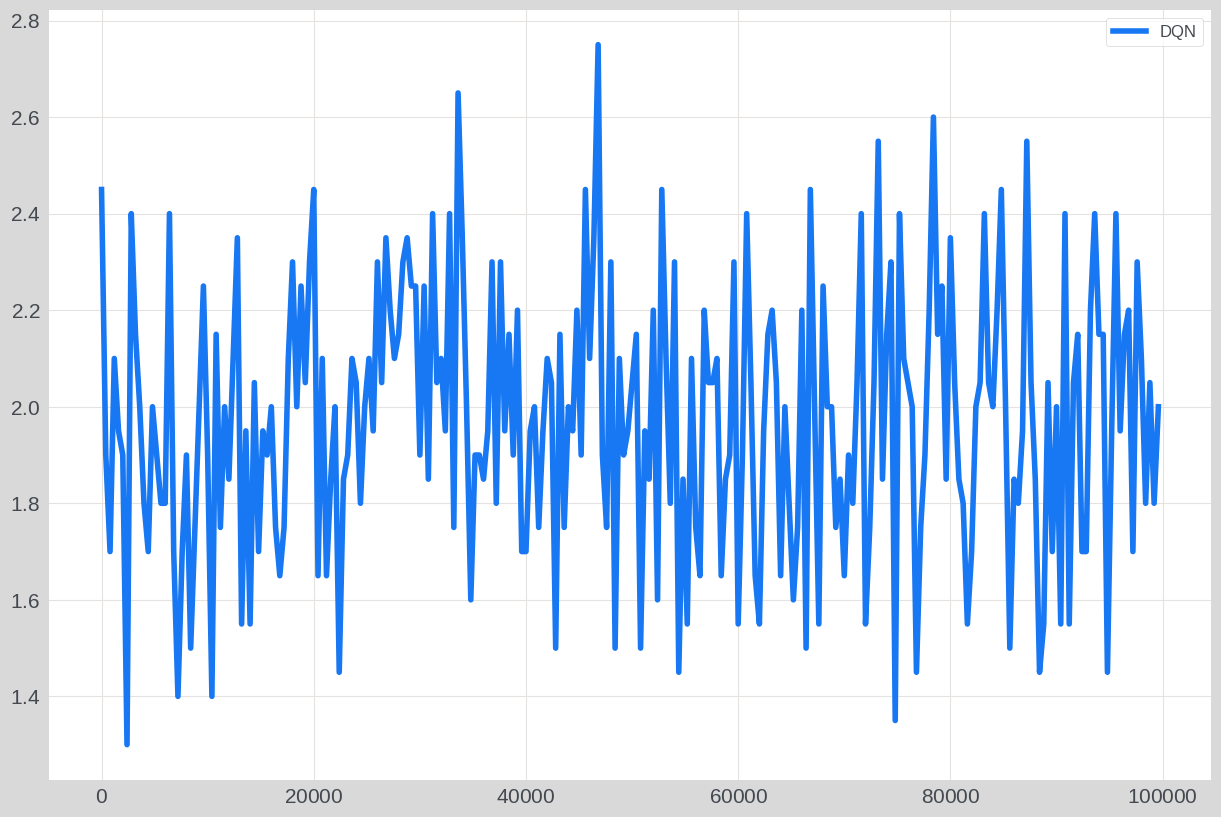

In [6]:
# create a pearl agent

action_representation_module = IdentityActionRepresentationModule(
    max_number_actions=action_space.n,
    representation_dim=action_space.action_dim,
)

# DQN-vanilla
agent = PearlAgent(
    policy_learner=DeepQLearning(
        state_dim=1,
        action_space=action_space,
        hidden_dims=[64, 64],
        training_rounds=50,
        action_representation_module=action_representation_module,
    ),
    replay_buffer=FIFOOffPolicyReplayBuffer(100_000),
    device_id=-1,
)

info = online_learning(
    agent=agent,
    env=env,
    number_of_steps=number_of_steps,
    print_every_x_steps=100,
    record_period=record_period,
    learn_after_episode=True,
)
torch.save(info["return"], "DQN-return.pt")
plt.plot(record_period * np.arange(len(info["return"])), info["return"], label="DQN")
plt.legend()
plt.show()

## DQN Agent with LSTM history summarization module

Now the DQN agent can handle partially observable environments with history summarization

episode 5, step 100, agent=PearlAgent with DeepQLearning, LSTMHistorySummarizationModule(
  (lstm): LSTM(101, 128, num_layers=2, batch_first=True)
), FIFOOffPolicyReplayBuffer, env=<pearl.tutorials.single_item_recommender_system_example.env.RecEnv object at 0x7fa9e9719ba0>
return: 1.0
episode 10, step 200, agent=PearlAgent with DeepQLearning, LSTMHistorySummarizationModule(
  (lstm): LSTM(101, 128, num_layers=2, batch_first=True)
), FIFOOffPolicyReplayBuffer, env=<pearl.tutorials.single_item_recommender_system_example.env.RecEnv object at 0x7fa9e9719ba0>
return: 3.0
episode 15, step 300, agent=PearlAgent with DeepQLearning, LSTMHistorySummarizationModule(
  (lstm): LSTM(101, 128, num_layers=2, batch_first=True)
), FIFOOffPolicyReplayBuffer, env=<pearl.tutorials.single_item_recommender_system_example.env.RecEnv object at 0x7fa9e9719ba0>
return: 2.0
episode 20, step 400, agent=PearlAgent with DeepQLearning, LSTMHistorySummarizationModule(
  (lstm): LSTM(101, 128, num_layers=2, batch_firs

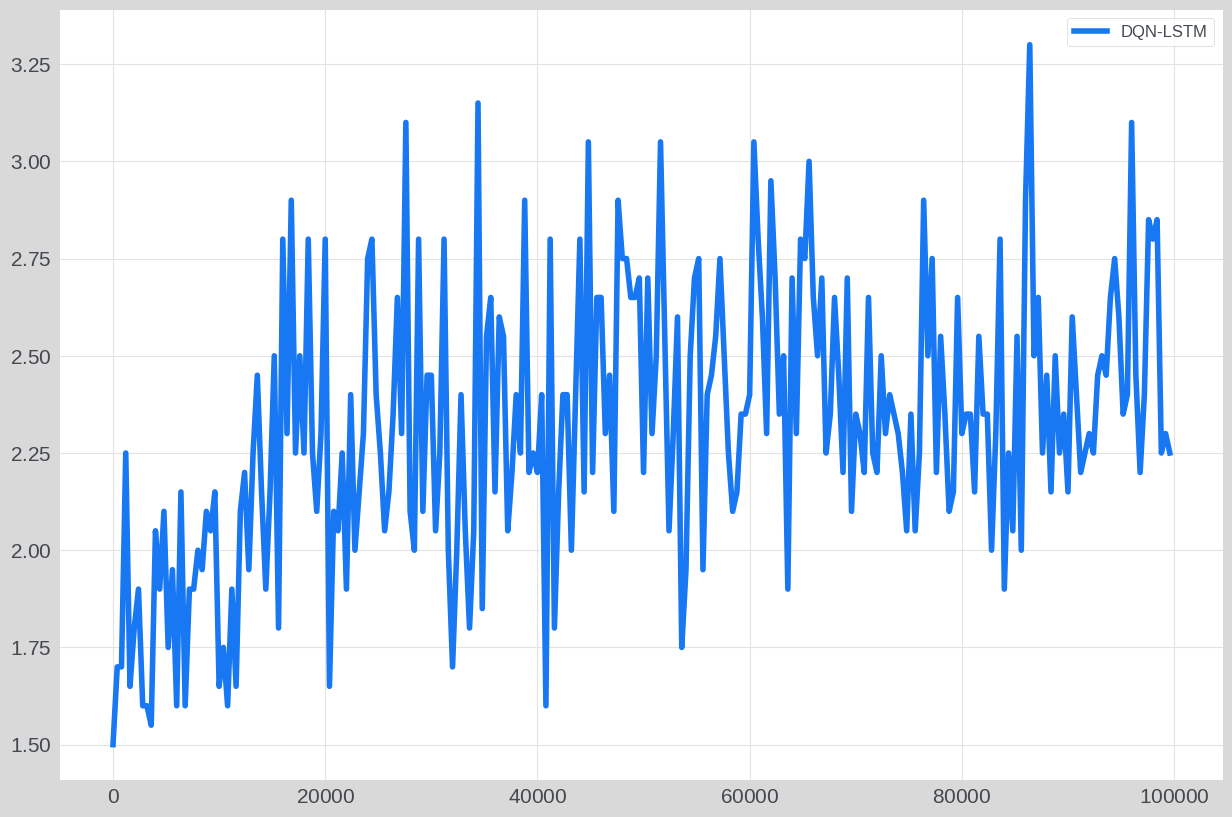

In [7]:
# Add a LSTM history summarization module

agent = PearlAgent(
    policy_learner=DeepQLearning(
        state_dim=128,
        action_space=action_space,
        hidden_dims=[64, 64],
        training_rounds=50,
        action_representation_module=action_representation_module,
    ),
    history_summarization_module=LSTMHistorySummarizationModule(
        observation_dim=1,
        action_dim=100,
        hidden_dim=128,
        history_length=8,
    ),
    replay_buffer=FIFOOffPolicyReplayBuffer(100_000),
    device_id=-1,
)

info = online_learning(
    agent=agent,
    env=env,
    number_of_steps=number_of_steps,
    print_every_x_steps=100,
    record_period=record_period,
    learn_after_episode=True,
)
torch.save(info["return"], "DQN-LSTM-return.pt")
plt.plot(record_period * np.arange(len(info["return"])), info["return"], label="DQN-LSTM")
plt.legend()
plt.show()

## Bootstrapped DQN Agent with LSTM History Summarization

Leveraging the deep exploration value-based algorithm, now the agent can achieve a better performance in a much faster way while being able to still leverage history summarization capability. Note how top average performance takes around 20,000 steps in the graph above, but only about 5,000 steps in the graph below.

episode 5, step 100, agent=PearlAgent with BootstrappedDQN, LSTMHistorySummarizationModule(
  (lstm): LSTM(101, 128, num_layers=2, batch_first=True)
), BootstrapReplayBuffer, env=<pearl.tutorials.single_item_recommender_system_example.env.RecEnv object at 0x7fa9e9719ba0>
return: 0.0
episode 10, step 200, agent=PearlAgent with BootstrappedDQN, LSTMHistorySummarizationModule(
  (lstm): LSTM(101, 128, num_layers=2, batch_first=True)
), BootstrapReplayBuffer, env=<pearl.tutorials.single_item_recommender_system_example.env.RecEnv object at 0x7fa9e9719ba0>
return: 0.0
episode 15, step 300, agent=PearlAgent with BootstrappedDQN, LSTMHistorySummarizationModule(
  (lstm): LSTM(101, 128, num_layers=2, batch_first=True)
), BootstrapReplayBuffer, env=<pearl.tutorials.single_item_recommender_system_example.env.RecEnv object at 0x7fa9e9719ba0>
return: 3.0
episode 20, step 400, agent=PearlAgent with BootstrappedDQN, LSTMHistorySummarizationModule(
  (lstm): LSTM(101, 128, num_layers=2, batch_first=Tr

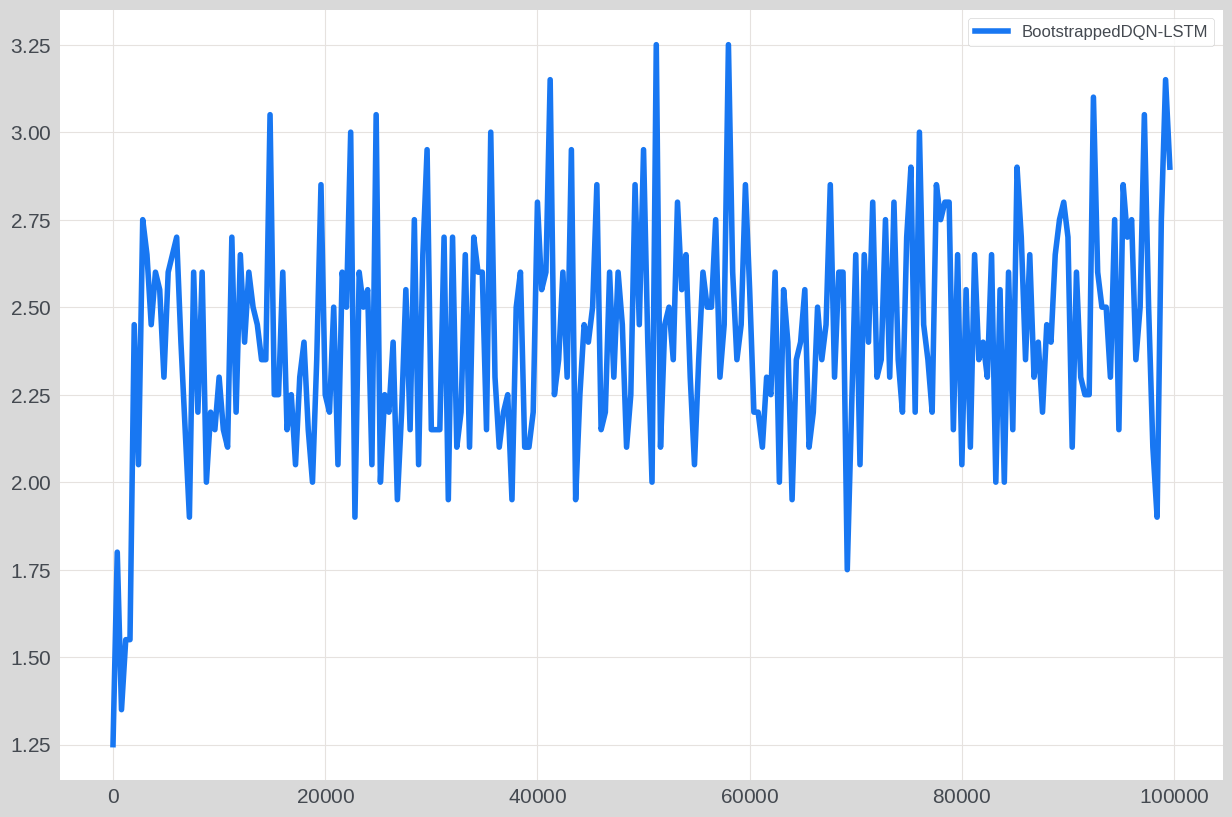

In [1]:
# Better exploration with BootstrappedDQN-LSTM

agent = PearlAgent(
    policy_learner=BootstrappedDQN(
        q_ensemble_network=EnsembleQValueNetwork(
            state_dim=128,
            action_dim=100,
            ensemble_size=10,
            output_dim=1,
            hidden_dims=[64, 64],
            prior_scale=0.3,
        ),
        action_space=action_space,
        training_rounds=50,
        action_representation_module=action_representation_module,
    ),
    history_summarization_module=LSTMHistorySummarizationModule(
        observation_dim=1,
        action_dim=100,
        hidden_dim=128,
        history_length=8,
    ),
    replay_buffer=BootstrapReplayBuffer(100_000, 1.0, 10),
    device_id=-1,
)

info = online_learning(
    agent=agent,
    env=env,
    number_of_steps=number_of_steps,
    print_every_x_steps=100,
    record_period=record_period,
    learn_after_episode=True,
)
torch.save(info["return"], "BootstrappedDQN-LSTM-return.pt")
plt.plot(record_period * np.arange(len(info["return"])), info["return"], label="BootstrappedDQN-LSTM")
plt.legend()
plt.show()

## Summary
In this example, we illustrated Pearl's capability of dealing with dynamic action space, standard policy learning, history summarization and intelligent exploration, all in a single agent.
